In [34]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple,deque
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import BSS_MODEL_demo1 as BMD
#import BSS_MODEL as BMD
#import BSS_FUNC
import BSS_ENV_demo as BED
#import BSS_ENVupdata as BED
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
class options:#environment setting
    def __init__(self,scale):
        self.charger_num = scale
        self.ev_num = scale
        self.maxpve = 500
        
        self.stateinp_dim = 5
        self.game_step = 350       

        self.data_folder = r'D:\sjtu\EV_DRL\GRU_MSPPO_demo\data' #data folder
        self.gru_state = os.path.join(self.data_folder,'gru.pth') 

        self.price_data = os.path.join(self.data_folder,'testpricedata.csv') 
        self.modelRR_dict =os.path.join(self.data_folder,'RR.pth') 
        self.modelRP_dict =os.path.join(self.data_folder,'RP.pth')  

OPTIONS = options(30)
pricedata_pd = pd.read_csv(OPTIONS.price_data)
pricedata_demo = np.array([max(0,i) for i in pricedata_pd['DK_1_price_day_ahead'].tolist()])
GM = BED.GameManager(evnum=OPTIONS.ev_num,chargernum= OPTIONS.charger_num, \
                               max_pv_eg= OPTIONS.maxpve,pvprice=70,\
                                ps_eprice_ds= pricedata_demo)

gru_model = BMD.GRU_price().to(device)
gru_model.load_state_dict(torch.load(OPTIONS.gru_state))

<All keys matched successfully>

In [36]:
def StateTensor():
    state,oldprice,coststate,isdone = GM.EnvState()
    old_price = gru_model(torch.tensor([oldprice]).unsqueeze(-1).detach().to(device)).item()#gru module priction
    statel = state.tolist()
    statel.append(old_price)
    state = torch.Tensor(statel).unsqueeze(0)
    coststate = torch.Tensor(coststate).unsqueeze(0)
    isdone = torch.tensor([isdone])
    return state,coststate,isdone

cost_cofcomb1 = 36 * 200
carbon_cofcomb1= 424* 200
def reward_type1(cost_state):
    cost = cost_state[:,0]
    carbon = cost_state[:,1]
    wait_ev = cost_state[:,2]
    wasted_eng=cost_state[:,3] 
    ps_pvps_reward = cost/cost_cofcomb1 + carbon/carbon_cofcomb1  
    wait_ev_reward = wait_ev  
    wasted_eng_reward = wasted_eng
    reward = (-1 * ps_pvps_reward - 1 * wait_ev_reward- 1*wasted_eng_reward )/OPTIONS.ev_num
    return reward.unsqueeze(0)

In [37]:
reward = reward_type1
bss_drl = BMD.BSS_DRL(OPTIONS,inpdim=OPTIONS.stateinp_dim,erdim=OPTIONS.charger_num+1,ifstep = True)
bss_drl.bss_RR.load_state_dict(torch.load(OPTIONS.modelRR_dict))
bss_drl.bss_RP.load_state_dict(torch.load(OPTIONS.modelRP_dict))

<All keys matched successfully>

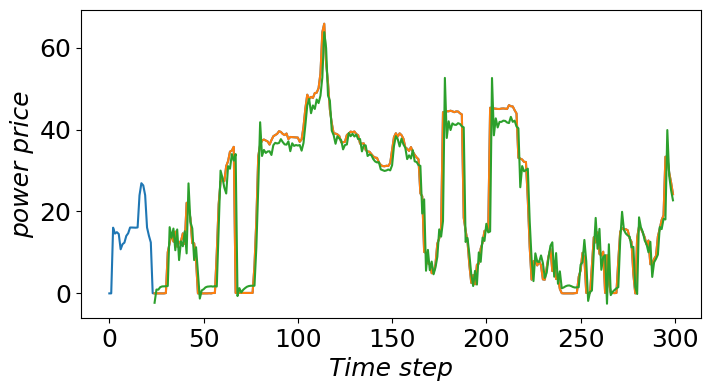

In [38]:
GM.Initial()
a = []
b = []
c = []
for i in range(300):
    state,oldprice,coststate,isdone = GM.EnvState()
    pre_price = gru_model(torch.tensor([oldprice]).unsqueeze(-1).to(device)).item()
    STATE,_,_ = StateTensor()
    a.append(pricedata_demo[i])
    b.append(GM.ps.price)
    c.append(STATE.squeeze()[-1])
    GM.Update(12)


x = np.arange(len(a))
fig,ax = plt.subplots(figsize = (8,4))
ax.plot(x,a)
ax.plot(x[24:],b[:len(a)-24])
ax.plot(x[24:],c[:len(a)-24])
ax.set_xlabel('Time step', fontsize=18,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('power price', fontsize='18',fontstyle='italic')
plt.tick_params(labelsize=18)
plt.show()

In [39]:
def test(step,gamemanager,rewardF, type_e = True,model1=None,showmessage = True):
    gamemanager.Initial( reinitial= True)
    gamemanager.Message()
    request_energy_list = []
    rew_list = []
    wait_nums = []
    ava_bs = []
    maxpvs = []
    rewards = 0
    gamestep = 0
    for i in range(step):
        gamestep += 1
        csta,_,_ = StateTensor()#gru module priction
        energy_act,pv_act,prob1,prob2 = 400,0, None,torch.tensor([[1,0]])
        if model1 != None:
            energy_act,pv_act,prob1,prob2 = model1.select_action(csta)
            #type1 for sample action
            # energy_req = int(energy_act.cpu().item())
            # pv_rat = pv_act.cpu().item()
            
            #type2 for max action
            energy_req=prob1.argmax().cpu().item()
            pv_rat =prob2.argmax().cpu().item()

        #energy req for step 1
        #pv for step 2
        gamemanager.Update(energy_req,pv_rat,1,type=type_e)
        _,ncost,isdone = StateTensor()
        rew =rewardF(ncost).cpu().item()
        wait_num = gamemanager.wait_evnum
        wait_nums.append(wait_num)
        avab = len(gamemanager.bss.BatteryT1_available)+len(gamemanager.bss.BatteryT2_available)#
        ava_bs.append(avab)
        request_energy_list.append(energy_req)
        prob2 = prob2.cpu().detach()
        maxpvs.append(prob2.max(dim=1)[1].cpu().item())
        rew_list.append(rew)
        rewards += rew
        if showmessage:
            gamemanager.Message()
        if isdone==1:
            break

    def plotax(axsi,x,y,names):
        lines = []
        for i in y:
            li, = axsi.plot(x, i)
            lines.append(li)
        axsi.legend(lines,names)

    _,axs = plt.subplots(4,1,figsize=(12,3*4))
    x = range(gamestep)
    plotax(axs[0],x,[request_energy_list],['request_energy'])
    plotax(axs[1],x,[wait_nums,ava_bs],['wait_nums','ava_bs'])    
    plotax(axs[2],x,[maxpvs],['maxpvs']) 
    plotax(axs[3],x,[rew_list],['rew_list'])
    axs[3].plot(x,rew_list)

    plt.show()
    return rew_list

stage 0 env inf
stage end, try swapping ev0, already request swapping0
in bss, available batteries 30


stage 1 env inf
EV BSS SWAP
swapping request num0,ava battery30, served ev0, T1 battery0

EV BSS SWAP end
charging plan[],curt cp[]
charging
working charging bays num
request charging bays num1, actual num0, need battery num 0. 
  total consume0, end num0
consume energy0,pv ratio0,pv0,grid0,carbon 0.0, energy price0.0
 energy from grid.co2 factor570.3 g/kWh.energy price0.0 $/kwh. usedenergy0. co20.0, expense0.0
 energy from pv.co2 factor40 g/kWh.energy price70 $/kwh. usedenergy0. co20, expense0
EV fleet：
EV0 in working state, soc consume0.04092831379794375, battery inf:
battery0,soc0.9591
if need swap: False
EV1 in working state, soc consume0.03636712611252322, battery inf:
battery1,soc0.9636
if need swap: False
EV2 in working state, soc consume0.03536712611252322, battery inf:
battery2,soc0.9646
if need swap: False
EV3 in working state, soc consume0.037367126112523213, battery inf:


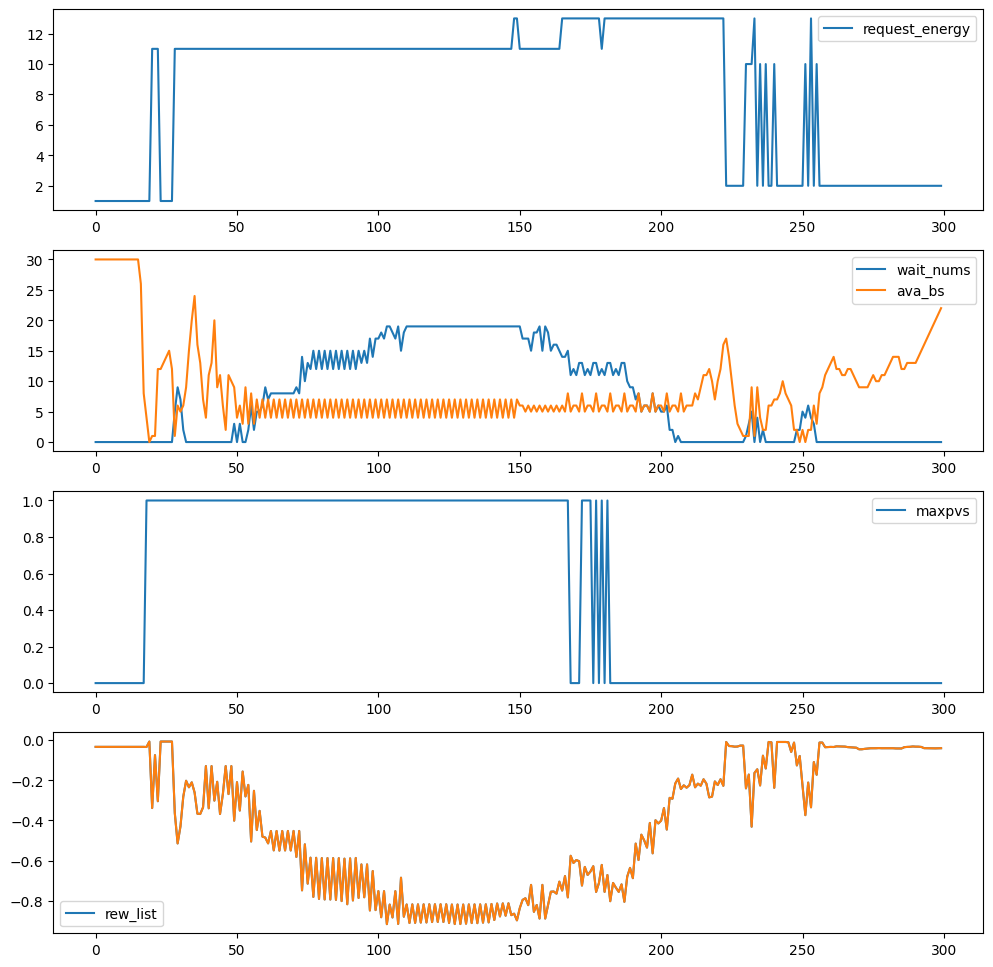

-124.42284203972667

In [40]:
rews =test(300,gamemanager=GM,rewardF=reward_type1,type_e=False,model1=bss_drl,showmessage=True)
sum(rews)